# Implicitly defined reachable sets within GCS

In [8]:
import numpy as np
from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph

# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

## Simple Example Graph

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 31726.96it/s]


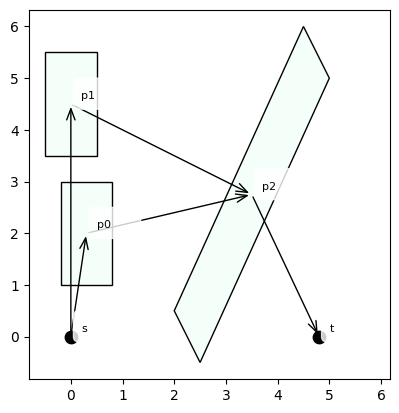

In [9]:
g = create_simplest_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=false and preprocessing=false and no rounding.


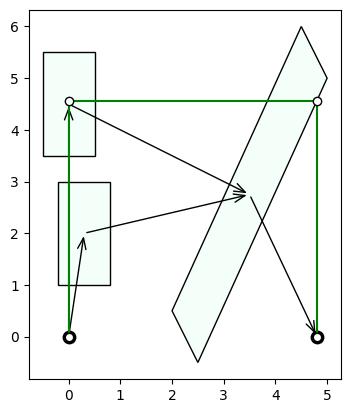

In [10]:
sol = g.solve_shortest_path()
g.plot_sets()
g.plot_edges()
g.plot_path(sol.ambient_path)

In [ ]:
# print(g.edge_keys)
# sol_conv_res = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

# sol_conv_res
# g.plot_sets()
# g.plot_path(sol_conv_res.ambient_path)

In [ ]:
for vertex_name, v in g.vertices.items():
    print(vertex_name, v.gcs_vertex.set().IsBounded())

# Sampling Procedure
To determine if A is dominated by B

In [ ]:
# Sample 100 points in p2
p2_samples = np.array(g.vertices["p2"].convex_set.get_samples(100))
g.plot_sets()
g.plot_points(p2_samples)

In [ ]:
# Project these samples into revised set based on path


def project_sample_to_revised_set(sample, vertex_sampled, active_edges):
    prog = MathematicalProgram()
    vertex_names = [active_edges[0][0]] + [edge[1] for edge in active_edges]
    # gcs vertices
    vertices = [g.vertices[name].gcs_vertex for name in vertex_names]
    edges = [g.edges[edge].gcs_edge for edge in active_edges]
    for v in vertices:
        if v.set().ambient_dimension() == 0:
            continue
        prog.AddDecisionVariables(v.x())
        v.set().AddPointInSetConstraints(prog, v.x())

        # Vertex Costs
        for binding in v.GetCosts():
            prog.AddCost(binding)
        # Vertex Constraints
        for binding in v.GetConstraints():
            prog.AddConstraint(binding)

    for e in edges:
        # Edge Costs
        for binding in e.GetCosts():
            prog.AddCost(binding)
        # Edge Constraints
        for binding in e.GetConstraints():
            prog.AddConstraint(binding)

    result = Solve(prog)
    if not result.is_success():
        raise RuntimeError("Failed to solve")
    return result


# active_edges = [("s", "p1"), ("p1", "p2")]
active_edges = [("s", "p1"), ("p1", "p2"), ("p2", "t")]
res = project_sample_to_revised_set(p2_samples[0], "p2", active_edges)
print(f"optimal_cost: {res.get_optimal_cost()}")
print(sol.cost)

# GcsAstarReachability

In [1]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
import numpy as np

from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph, create_polyhedral_hor_vert_graph
# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

In [2]:
g = create_simplest_hor_vert_graph()
# g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarReachability(g, cost_estimator_se, num_samples_per_vertex=5)
sol = alg.run()

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 30750.03it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge s -> p0
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:conv_res_active_edges: ["('s', 'p0')", "('p0', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p0')", "('p0', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:is_success: True
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:Removing edge ('p0', 't')_shortcut
DEBUG:large_gcs.algorithms.gcs_astar_reachability:edge s -> p0 is feasible
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge s -> p1
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:conv_res_active_edges: ["('s', 'p1')", "('p1', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:active edge keys: ["('s', 'p1')", "('p1', 't')_shortcut"]
DEBUG:large_gcs.graph.graph:is_success: True
DEBUG:large_gcs.cost_estima

In [ ]:
str(sol)

In [ ]:
# g.edges["('p0', 'p0_sample_1')"]

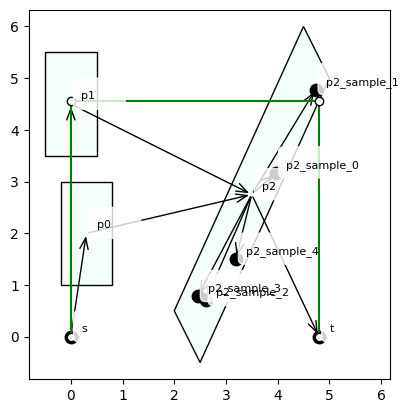

In [4]:
g.plot_sets()
g.plot_edges()
g.plot_set_labels()
g.plot_path(sol.ambient_path)

In [ ]:
# sol = g.solve_convex_restriction([('s', 'p1'), ('p1', 'p1_sample_0')])
# sol = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

In [ ]:
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction

g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarConvexRestriction(g, cost_estimator_se)
sol = alg.run()

Note how GcsAstarConvexRestriction fails because it doesn't have the sampling to determine reachability procedure that GcsAstarReachability has

# Applying GcsAstarReachability to Contact Graph that fails for GcsAstarConvexRestriction
cg_maze_b1

In [6]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
import numpy as np

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.INFO)

In [7]:
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams

# cg_maze_b1_1 cg_maze_b1
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_trichal2")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
cost_estimator = ShortcutEdgeCE(
    cg,
    shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted,
)
alg = GcsAstarReachability(cg, cost_estimator, num_samples_per_vertex=5)
sol: ShortestPathSolution = alg.run()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 25266.89it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15141.89it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 64.47it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (100)
100%|██████████| 100/100 [00:00<00:00, 863.14it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') -> ('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')
INFO:large_gcs.algorithms.gcs_astar_reachability:exploring edge ('NC|obs0_f0-obj0_v3', 'NC

The equality constraints on edges can collapse the feasible region in the next set to some measure 0 subspace which then have probability 0 of being sampled